### Simple CNN regression with Tensorflow

In [1]:
import xarray as xr
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
pd.__version__

'2.2.1'

### Data preprocessing

In [3]:
# Be sure to download this data from GDrive, or from /public on DataHub
delta_SST_10deg = xr.open_dataarray("_data/delta_SST_10deg.nc")
delta_SST_10deg

<xarray.DataArray (idx: 5545, lat: 14, lon: 19)> Size: 12MB
[1474970 values with dtype=float64]
Coordinates:
    time_avg  <U6 24B ...
  * idx       (idx) int64 44kB 0 1 2 3 4 5 6 ... 5539 5540 5541 5542 5543 5544
  * lat       (lat) float32 56B 84.38 71.88 59.38 46.88 ... -53.12 -65.62 -78.12
  * lon       (lon) float32 76B 8.438 27.19 45.94 64.69 ... 308.4 327.2 345.9

In [4]:
delta_precip = xr.open_dataarray("_data/tropical_annual_precip.nc")
delta_precip

<xarray.DataArray (idx: 5545)> Size: 44kB
[5545 values with dtype=float64]
Coordinates:
    time_avg  <U6 24B ...
  * idx       (idx) int64 44kB 0 1 2 3 4 5 6 ... 5539 5540 5541 5542 5543 5544
    lat       float64 8B ...
    lon       float64 8B ...
Attributes:
    regrid_method:  bilinear

In [5]:
# Add a 'feature' dimension
delta_precip = delta_precip.expand_dims(["feature"], axis=1)

# Add a 'channel' dimension
delta_SST_10deg = delta_SST_10deg.expand_dims(["channel"], axis=-1)

In [6]:
Y_scaler = StandardScaler()
Y = Y_scaler.fit_transform(delta_precip)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(delta_SST_10deg, Y, test_size=0.2, random_state=42)

In [8]:
# This is the per-sample 'image' shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)
input_shape

(14, 19, 1)

### Model building/hyperparameter tuning

In [9]:
def create_model(lr=1e-3, 
                 optimizer='Adam', 
                 kernel_size=3, 
                 pooling_kernel_size=2, 
                 n_layers=3,
                 n_filters=16, 
                 n_dense_neurons=32,
                 dropout=True):
    
    model = models.Sequential()
    
    # n_layers refers to number convolutional + max pooling layers
    for i in range(n_layers):
        model.add(layers.Conv2D((2**i * n_filters), kernel_size, activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D(pooling_kernel_size))
  
    # flatten and feed into fully-connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(n_dense_neurons, activation='relu')) # highly sensitive
    if dropout:
        model.add(layers.Dropout(0.1))
    model.add(layers.Dense(16, activation='relu'))
    
    # regress
    model.add(layers.Dense(1, activation='linear'))
    
    if optimizer == 'Adam':
        optimizer = optimizers.Adam(learning_rate=lr)
    elif optimizer == 'SGD':
        optimizer = optimizers.SGD(learning_rate=lr)
        
    model.compile(loss='mean_squared_error', # one may use 'mean_absolute_error' as  mean_squared_error
                  optimizer=optimizer)
    
    return model

In [10]:
model = create_model(lr=1e-2, 
                     optimizer='Adam', 
                     kernel_size=(3, 2), 
                     n_layers=2, 
                     n_filters=4,
                    n_dense_neurons=32)
model.summary()

/Users/watson-parris/miniconda3/envs/sio209_dev/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
2025-04-21 22:06:06.912163: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2025-04-21 22:06:06.912183: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-04-21 22:06:06.912189: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2025-04-21 22:06:06.912208: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-21 22:06:06.912217: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow d

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 12, 18, 4)      │            28 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 6, 9, 4)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 4, 8, 8)        │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 4, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,853 (11.14 KB)

 Trainable params: 2,853 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
batch_size = 128
epochs = 30

history = model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          validation_split=0.2)

score = model.evaluate(X_test, Y_test, verbose=0)

Epoch 1/30


2025-04-21 22:06:07.800625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-21 22:06:07.802412: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


28/28 - 3s - 113ms/step - loss: 0.9764 - val_loss: 0.9527
Epoch 2/30
28/28 - 0s - 9ms/step - loss: 0.9340 - val_loss: 0.9057
Epoch 3/30
28/28 - 0s - 8ms/step - loss: 0.9062 - val_loss: 0.8902
Epoch 4/30
28/28 - 0s - 8ms/step - loss: 0.8485 - val_loss: 0.8505
Epoch 5/30
28/28 - 0s - 8ms/step - loss: 0.8260 - val_loss: 0.8297
Epoch 6/30
28/28 - 0s - 8ms/step - loss: 0.7827 - val_loss: 0.7924
Epoch 7/30
28/28 - 0s - 8ms/step - loss: 0.7732 - val_loss: 0.8186
Epoch 8/30
28/28 - 0s - 8ms/step - loss: 0.7619 - val_loss: 0.7894
Epoch 9/30
28/28 - 0s - 8ms/step - loss: 0.7414 - val_loss: 0.7707
Epoch 10/30
28/28 - 0s - 8ms/step - loss: 0.7353 - val_loss: 0.7668
Epoch 11/30
28/28 - 0s - 8ms/step - loss: 0.7205 - val_loss: 0.7865
Epoch 12/30
28/28 - 0s - 8ms/step - loss: 0.7236 - val_loss: 0.7664
Epoch 13/30
28/28 - 0s - 8ms/step - loss: 0.7007 - val_loss: 0.7637
Epoch 14/30
28/28 - 0s - 8ms/step - loss: 0.7026 - val_loss: 0.7678
Epoch 15/30
28/28 - 0s - 8ms/step - loss: 0.7057 - val_loss: 0.768

### Evaluation and comparison with linear approach

In [12]:
# CNN validation predictions
preds = model.predict(X_test)
preds = preds[:,0]

Y_test = Y_scaler.fit_transform(Y_test)

preds = Y_scaler.fit_transform(preds.reshape(-1,1))

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


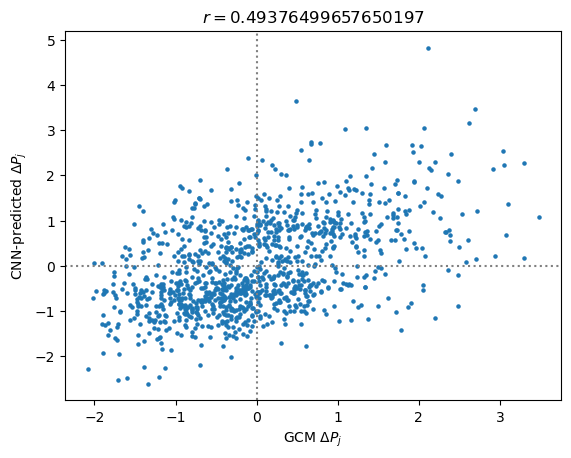

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.scatter(Y_test, preds, s=5)
r = np.corrcoef(Y_test.flatten(), preds.flatten())[0,1]
plt.setp(ax, xlabel='GCM $\Delta P_j$', ylabel='CNN-predicted $\Delta P_j$', title=f'$r={r}$')
ax.axvline(x = 0, color = 'grey', label = 'y-axis', ls=':')
ax.axhline(y = 0, color = 'grey', label = 'x-axis', ls=':')
